   # Quantifying rankings bias
   ### A quick example on a synthetic netwok
   
   Recently we have developed a statistical framework to quantify ranking biases [1]. Our framework is based on two simple ideas: first, we define an unbiased selection process from a null model and then we use the Mahalanobis distance [2] to compare the observed rankings against what is expected from the null model.  
   For this example, we grow a synthetic network using the linear preferential attachment rule [3]. The syntethic network will represent the observed system. Afterwards, we rank the nodes depending on their degree or PageRank score and show that the top of this ranking is biased by the age of the nodes. The age of a node is defined by the time at which the node entered into the network.
   
   1. G. Vaccario, M. Medo, N. Wider, M.S. Mariani: **Quantifying and suppressing ranking bias in a large citation network** [[1703.08071]](https://arxiv.org/abs/1703.08071)
   2. [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance)
   3. [Barabasi-Alber model](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model)

In [1]:
import numpy as np
import igraph
import matplotlib
import matplotlib.pyplot as plt

from quantbias import *
from mhd import *
from IPython.display import * 
from IPython.display import HTML                             

### The syntethic network

Let start with creating a syntethic network.
We have defined some functions at the end of this example page to grow a directed scale-free network.
To grow such network we use the linear preferentical attachment rule for which it is well-know that the degree of the nodes is strongly correlated to their age, i.e. when they entered in the network.

In [2]:
no_of_nodes = 1000
no_of_links = 4
cit_net = igraph.Graph.Barabasi(no_of_nodes,no_of_links)
igraph.summary(cit_net)

IGRAPH U--- 1000 3990 -- 


To visualize the network we use various plotting feature of igraph.
First, we use the Fruchterman-Reingold layout.

In [3]:
layout = cit_net.layout('fr')

We scale the size of the nodes accordingly to their IN-degree

In [4]:
visual_style={}
visual_style["vertex_size"]=[4 + 2*np.log(i+1) for i in cit_net.degree(mode = "IN")]

and color the nodes from light to dark purple for older and younger nodes, respectively.

In [5]:
visual_style["vertex_color"]=[]
min_light = 0.2
palette = [plt.cm.Purples]
for i in range(no_of_nodes):
    color = palette[0](min_light + (i-min_light)/no_of_nodes)#older nodes lighter color
    visual_style["vertex_color"].append("rgb"+str(tuple(x*255 for x in color[:3])))       

Finally, we the edges small in order to make more presentable the image of the network.

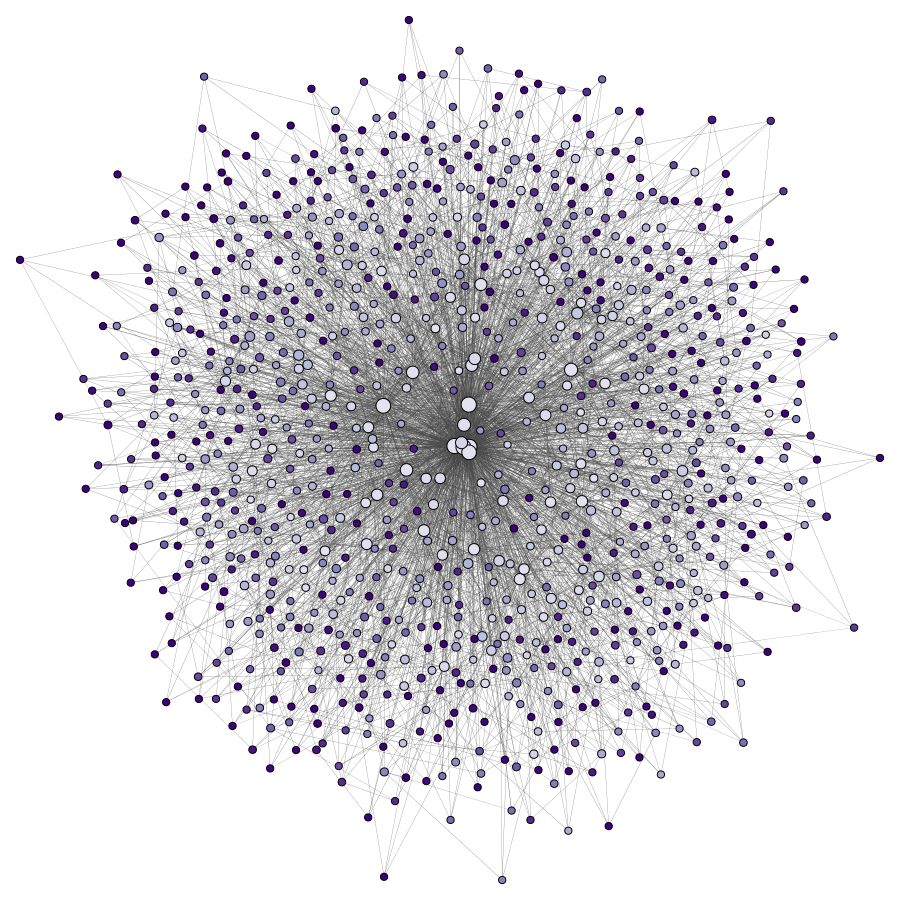

In [6]:
visual_style["edge_width"]=0.2
visual_style["edge_arrow_size"] = 0.2
visual_style["bbox"] = (900, 900)
visual_style["layout"]=layout
filename="temp"+'.png'
igraph.plot(cit_net,filename, **visual_style)
display(Image(filename=filename))

This synthetic network will represent our observed network on which we will test for age bias. From the mechanimis used to grow the network, we already know that the older nodes are the ones that enter the network at the begging.
We can easily show this by for example dividing the nodes in $F=10$ age groups with equal size. Then, we check the categories to which 10% of the nodes with higher degree, or page rank, belong.

In [7]:
#Number of categories
F=10
#Vector containing the *number* of publications in each category
#for this example we assume equal categorie size
m=[int(no_of_nodes/F) for i in range(F) ]
#Top-z% that we wish to sample
percentage = 10
#Total number of publication (with repetition)
N=sum(m)
#Number of publication belonging to the top-z%
no_of_publication_to_draw = int(np.floor(percentage*N)/100)

In [8]:
#Then, we obtain the degree sequence and the PageRank scores from the network
obs_Cit = cit_net.degree(mode = "IN")
obs_PageRagnk = cit_net.pagerank(directed = "True")
#We rank our papers/nodes according to their degree and pagerank
CIT_ranking = np.argsort(-np.array(obs_Cit))
PGR_ranking = np.argsort(-np.array(obs_PageRagnk))
#We keep only the top-z% of the ranking
top_CIT_rank = CIT_ranking[:no_of_publication_to_draw]
top_PGR_rank = PGR_ranking[:no_of_publication_to_draw]

In [9]:
#Create a dictionary where each entry is a paper/node with its category
#OBS. If the paper/nodes belongs to more than one category, we should assign a list
pub_category = {}
cat=0
count=0
for i in range(no_of_nodes):
    if count>=int(no_of_nodes/F):
        cat+=1
        count=0
    pub_category[i] = cat
    count+=1#Create the ranking vectors, 
#i.e. the vector containing the number of papers/nodes belonging to each categeory in the top-z%
CIT_rank_vect = [0 for i in range(F)]
for cat in top_CIT_rank:
    CIT_rank_vect[pub_category[cat]]+=1
PRG_rank_vect = [0 for i in range(F)]
for cat in top_CIT_rank:
    PRG_rank_vect[pub_category[cat]]+=1

In [10]:
CIT_rank_vect

[64, 25, 9, 2, 0, 0, 0, 0, 0, 0]

We can see that most of the nodes that belong to the first category, 
i.e. older nodes are the ones which have higher degree, while younger nodes have a much smaller degree.
A similar observations olds for the Page Rank scores.

In [11]:
PRG_rank_vect

[64, 25, 9, 2, 0, 0, 0, 0, 0, 0]

Now, if we forget that the synthetic network was growth 
using a linear preferential attachment rule, how can we check and say that the ranking of the nodes is biased towards older?
One simple approach would be to correlate the degree of the nodes to their age.
With this we would show that there is correlation, while a bias should a systematic deviation from expected values.
In the following, we introduce a null model which enables to define the expected values and an unbiased selection process which generates it.

### The Null Model
The null model we assume is the one presented in [1].
Here, we quickly summarize the main ideas:
    1. take a urn
    2. color each node depending on the category to which it belongs
    3. put the nodes in the urn
    4. sample uniformly at random n-nodes from the urn to create a ranking
With this, we simulate an unbiased selection process because the age of the nodes play no role in the sampling process. 
Moreover, this process has been well-studied and for it is to derive analytic results.
The most important one is the probability of the sequences, the multivariate hypergeometric distribution (MHD), the expected sequence(vector) and the covariance matrix.

The elements of the expected vector are simple: $\mu_i=n K_i/N$, where $N$ is the number of nodes, $K_i$ is the number of nodes beloging to category $i$ and n are the number of sampled nodes.

In [12]:
multivariate_hypergeometric_expected_vector(no_of_publication_to_draw, m)

array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.])

While the covariance matrix is not diagonal and looks more complicated (see [1] for details):

In [13]:
multivariate_hypergeometric_covariance_matrix(no_of_publication_to_draw, m)

array([[ 8.10810811, -0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 ,
        -0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 ],
       [-0.9009009 ,  8.10810811, -0.9009009 , -0.9009009 , -0.9009009 ,
        -0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 ],
       [-0.9009009 , -0.9009009 ,  8.10810811, -0.9009009 , -0.9009009 ,
        -0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 ],
       [-0.9009009 , -0.9009009 , -0.9009009 ,  8.10810811, -0.9009009 ,
        -0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 ],
       [-0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 ,  8.10810811,
        -0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 ],
       [-0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 ,
         8.10810811, -0.9009009 , -0.9009009 , -0.9009009 ],
       [-0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 ,
        -0.9009009 ,  8.10810811, -0.9009009 , -0.9009009 ],
       [-0.9009009 , -0.9009009 , -0.9009009 , -0.9009009 , -0

We can also simulate the process described in the 4 steps and then check which kind of rankings are created:

In [14]:
multivariate_hypergeometric_sampling(no_of_publication_to_draw, m, simul=1)

[array([ 6, 12, 13, 10, 16,  9,  7,  9,  9,  9])]

The ranking vector created using the sampling procedure is actually different from the one the expected vector/sequence. But since it is created using the unbiased sampling procedure we should consider it biased, even though the first category is still the most represented one.
How can we quantify the difference between this vector and the ranking vector obtained from the syntethic network?

### The Mahalanobis Distance
The Mahalanobis Distance, $d_{\mathcal{M}}$, is a standard measure used in statistic that permits to quantify the difference between an observation and a distribution. Precisely, if we observer a vector $\mathbf{x}^{T}=(x_1, \dots,x_F)$, its $d_{\mathcal{M}}$ from a set of observations with mean $\vec{\mu}^{T}=(\mu_1, \dots ,\mu_F)$ is  

\begin{equation}
d_{\mathcal{M}}(\vec{x},\vec{\mu})=\sqrt{(\vec{x}-\vec{\mu})^{T} S^{-1}(\vec{x}-\vec{\mu})}
\end{equation}

where $S^{-1}$ is the inverse of the covariance matrix of the set of observations.
Those people which have been working with metric spaces, rather than distributions, can intepret this measure as the distance between the observation and the expected vector in space where in a space where the metric is defined using the inverse of the covariance matrix of the distribution. To understand the role of this matrix think of a simple case where the covariance matrix have only diagonal elements: the bigger are these diagonal elments more scattered are the observations and the determinant represents how much volume the observations occupy in the space.
In addition, the $d_{\mathcal{M}}$ for a diagonal covariance matrix is equivalent to the root of the sum of squares of the $z$-scores, i.e. $d_{\mathcal{M}}^2=\sum_i^F{ \left(\frac{  {x_i}-\mu_i}{\sigma_i} \right)^2}$

Above we have shown that the covariance matrix coming from the MHD is not diagonal so we cannot use this simplification. 
However, we have obtained a simular formula for the MHD case:

\begin{equation}
d_{\mathcal{M}}(\vec{x},\vec{\mu}) = \sqrt{ \sum_i^F \left(\frac{  {x_i}-\mu_i}{\sigma_i} \right)^2 \left(1 - \frac{k_i}{N}\right)}
\end{equation}

We can check that for to random vector the two formulas give the similar results. We believe that the results are not identical depending on the fact that the matrix inversion in python is multiplicative, i.e. "numpy.linalg.inv(A) actually calls numpy.linalg.solve(A,I), where I is the identity, and solve uses lapack's LU factorization." (see [here](http://stackoverflow.com/questions/16569613/how-does-numpy-linalg-inv-calculate-the-inverse-of-an-orthogonal-matrix)).

In [15]:
simul = 10000
sampling = multivariate_hypergeometric_sampling(no_of_publication_to_draw, m, simul=10000) 

In [16]:
print("Calulating the MD for the sampled vectors obtained with the unbaiased selection process")
print("Using explicit formula for the multivariate hypergeometric distribution")
sampled_MD_1 = []
mu = multivariate_hypergeometric_expected_vector(no_of_publication_to_draw, m)
for x in sampling:
    sampled_MD_1.append(multivariate_hypergeometric_Mahalanobis_distance(x,
                                                                         mu,
                                                                         m)[0]
                      )

Calulating the MD for the sampled vectors obtained with the unbaiased selection process
Using explicit formula for the multivariate hypergeometric distribution


In [17]:
print("Calulating the MD for the sampled vectors obtained with the unbaiased selection process")
print("Using general formula for the multivariate hypergeometric distribution")
sampled_MD_2 = []
mu = multivariate_hypergeometric_expected_vector(no_of_publication_to_draw, m)
cov_mat = multivariate_hypergeometric_covariance_matrix(no_of_publication_to_draw, m)
inv_cov = np.linalg.inv(cov_mat)
for x in sampling:
    sampled_MD_2.append(Mahalanobis_distance(x[:-1],# we have to remove the last component
                                            mu[:-1],# we have to remove the last component
                                            inv_cov)
                      )

Calulating the MD for the sampled vectors obtained with the unbaiased selection process
Using general formula for the multivariate hypergeometric distribution


When we check that the obtained sampled vectors are the *identical*, we obtain *False*

In [18]:
sampled_MD_1==sampled_MD_2

False

However, the two values are identical for more than 10 decimal digits:

In [19]:
sum(np.abs(np.array(sampled_MD_1)-sampled_MD_2))

4.4176884372859604e-12

In addition, we can also see that numpy method allclose returns a positive result:

In [20]:
#print("Lets check that the values are similar/close from both methods")
np.allclose(sampled_MD_1,sampled_MD_2)

True

### Comparing the observerd rankings with the unbiased selection process

We now calculate the $d_{\mathcal{M}}$ of the ranking vectors coming from indegree and PageRank.
Then, we compare their bias with the one coming form the simulations of the unbiased selection process.

In [21]:
md_CIT, md_CIT_vect = multivariate_hypergeometric_Mahalanobis_distance(CIT_rank_vect, mu, m)
md_PGR, md_PGR_vect = multivariate_hypergeometric_Mahalanobis_distance(PRG_rank_vect, mu, m)

In [22]:
print("The bias of the top-",percentage,"% ranking created using Indegree, i.e. citation count is")
print(np.round(md_CIT, decimals=2))
p_CIT = -np.sort(-md_CIT_vect)[0]/md_CIT/md_CIT*100
p_cat_CIT = np.argsort(-md_CIT_vect)[0]
print(np.round(p_CIT, decimals=1),"% of the bias can be explained by the category number", p_cat_CIT)

The bias of the top- 10 % ranking created using Indegree, i.e. citation count is
20.55
76.6 % of the bias can be explained by the category number 0


In [23]:
print("The bias of the top-",percentage,"% ranking created using Indegree, i.e. citation count is")
print(np.round(md_PGR, decimals=2))
p_PGR = -np.sort(-md_PGR_vect)[0]/md_CIT/md_CIT*100
p_cat_PGR = np.argsort(-md_PGR_vect)[0]
print(np.round(p_PGR, decimals=1),"% of the bias can be explained by the category number", p_cat_PGR)

The bias of the top- 10 % ranking created using Indegree, i.e. citation count is
20.55
76.6 % of the bias can be explained by the category number 0


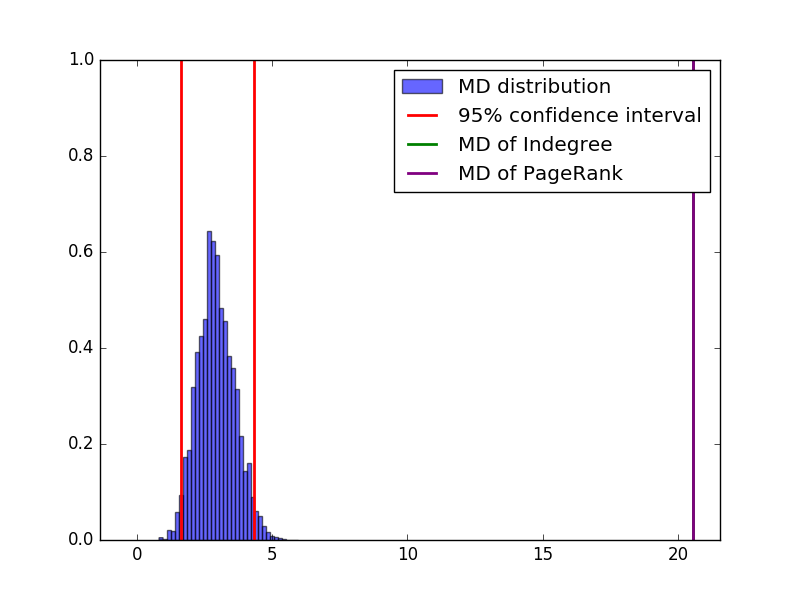

In [24]:
plt.hist(sampled_MD_2, bins=35, normed=True, alpha=0.6, color = 'b', label = "MD distribution")
upper_b = np.sort(sampled_MD_2)[int(97.5*simul/100)]
lower_b = np.sort(sampled_MD_2)[int(2.5*simul/100)]
plt.vlines(upper_b, 0 ,1, lw=2, color='r', label="95% confidence interval")
plt.vlines(lower_b, 0 ,1, lw=2, color='r')
plt.vlines(md_CIT, 0 , 1, lw=2, color ="g", label="MD of Indegree")
plt.vlines(md_PGR, 0 , 1, lw=2, color ="purple", label="MD of PageRank")
plt.xlim(lower_b-3,max(md_PGR,md_CIT,upper_b)+1)
plt.legend()
filename = 'MD_dist.png'
plt.savefig(filename)
plt.close()
display(Image(filename=filename))

For our example case, we have obtained that the ranking vectors 
from indegree and PageRank have the same bias. This happens because the number of nodes from each category is the same in both vectors, even thought the actual nodes are different.

In [25]:
CIT_rank_vect==PRG_rank_vect

True

In [26]:
sum(top_CIT_rank == top_PGR_rank)==no_of_publication_to_draw

False